# 12 Complete Vision System

PyTorch: 2.10.0+cu128
Torchvision: 0.25.0+cu128
Device: cuda
GPU disponibile: True


100%|██████████| 170M/170M [00:05<00:00, 32.0MB/s]


Training set: (50000, 32, 32, 3)
Test set: (10000, 32, 32, 3)
Range valori: [0, 255]
Classi: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


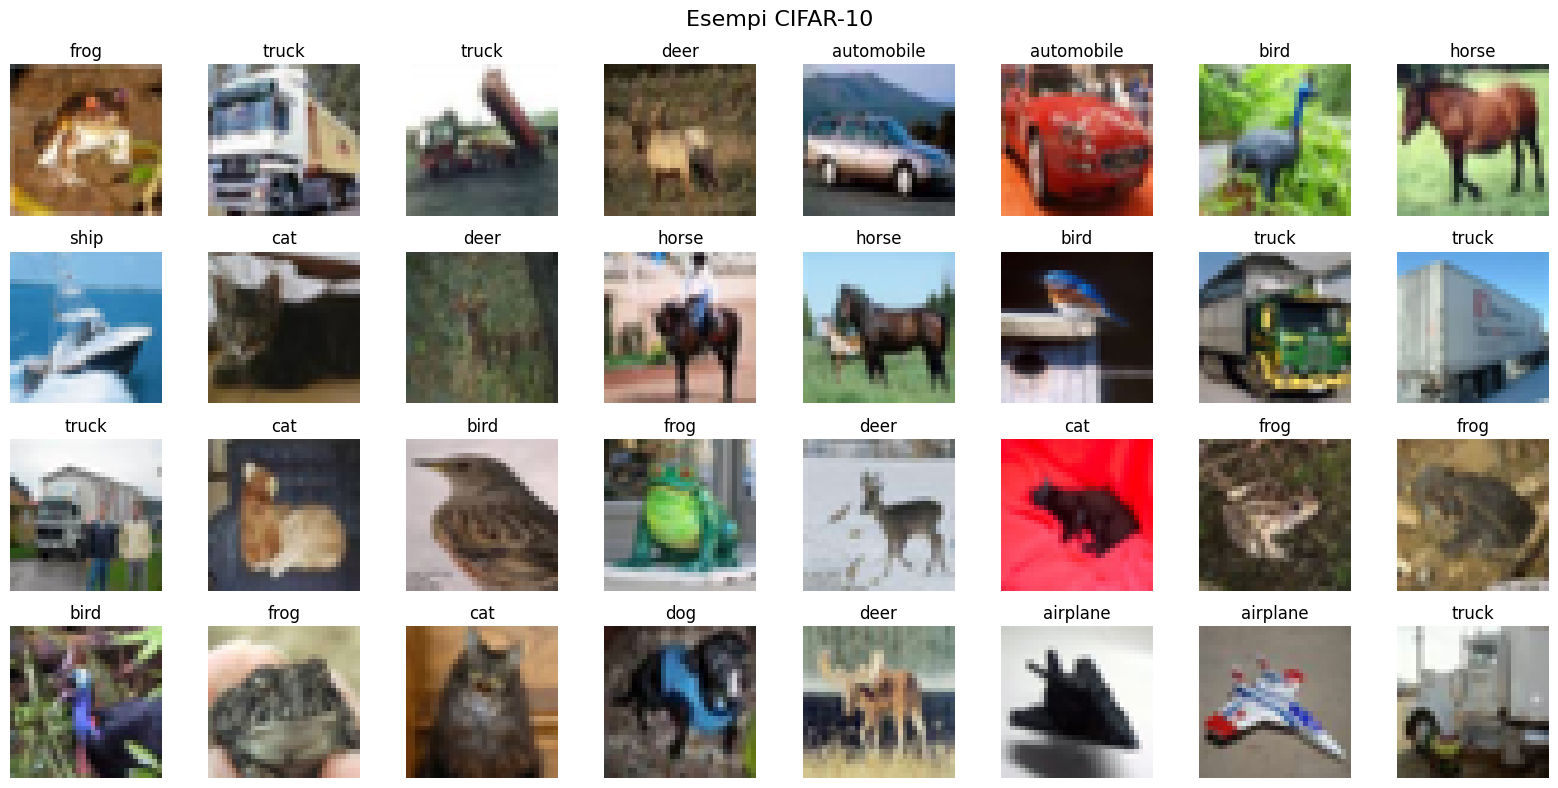

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"PyTorch: {torch.__version__}")
print(f"Torchvision: {torchvision.__version__}")
print(f"Device: {device}")
print(f"GPU disponibile: {torch.cuda.is_available()}")

# Caricamento CIFAR-10
transform_basic = transforms.ToTensor()

trainset_full = torchvision.datasets.CIFAR10(
    root='../data', train=True, download=True,
    transform=transform_basic
)
testset = torchvision.datasets.CIFAR10(
    root='../data', train=False, download=True,
    transform=transform_basic
)

# Per avere anche array numpy (utile per visualizzazioni)
trainset_raw = torchvision.datasets.CIFAR10(
    root='../data', train=True, download=True,
    transform=None
)
testset_raw = torchvision.datasets.CIFAR10(
    root='../data', train=False, download=True,
    transform=None
)

# Nomi classi CIFAR-10
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Estrai dati come numpy per preprocessing/visualizzazione
X_train = np.array([np.array(img) for img, _ in trainset_raw])
y_train = np.array([label for _, label in trainset_raw])
X_test = np.array([np.array(img) for img, _ in testset_raw])
y_test = np.array([label for _, label in testset_raw])

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Range valori: [{X_train.min()}, {X_train.max()}]")
print(f"Classi: {class_names}")

# Visualizzazione esempi
fig, axes = plt.subplots(4, 8, figsize=(16, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i])
    ax.set_title(class_names[y_train[i]])
    ax.axis('off')
plt.suptitle('Esempi CIFAR-10', fontsize=16)
plt.tight_layout()
plt.show()

import os, urllib.request

# GitHub Release URL for pretrained weights (update with actual URL)
WEIGHTS_BASE_URL = os.environ.get('WEIGHTS_URL', 'https://github.com/SamueleBolotta/CEAR/releases/download/v1.0/')
WEIGHTS_DIR = '../pretrained_weights'
os.makedirs(WEIGHTS_DIR, exist_ok=True)

def load_or_train(model, train_fn, weights_filename, device='cpu'):
    """Load pretrained weights if available, otherwise train and save.
    Also saves/loads training history as JSON alongside weights."""
    weights_path = os.path.join(WEIGHTS_DIR, weights_filename)
    history_path = weights_path.replace('.pt', '_history.json')

    def _load_history():
        if os.path.exists(history_path):
            import json as _json
            with open(history_path, 'r') as f:
                return _json.load(f)
        return None

    if os.path.exists(weights_path):
        model.load_state_dict(torch.load(weights_path, map_location=device, weights_only=True))
        print(f"Loaded pretrained weights from {weights_path}")
        return _load_history()
    elif WEIGHTS_BASE_URL:
        try:
            url = WEIGHTS_BASE_URL + weights_filename
            urllib.request.urlretrieve(url, weights_path)
            try:
                urllib.request.urlretrieve(
                    WEIGHTS_BASE_URL + weights_filename.replace('.pt', '_history.json'), history_path)
            except Exception:
                pass
            model.load_state_dict(torch.load(weights_path, map_location=device, weights_only=True))
            print(f"Downloaded and loaded weights from {url}")
            return _load_history()
        except Exception as e:
            print(f"Could not download weights: {e}. Training from scratch...")

    history = train_fn()
    torch.save(model.state_dict(), weights_path)
    print(f"Saved weights to {weights_path}")
    if history is not None:
        import json as _json
        with open(history_path, 'w') as f:
            _json.dump(history, f)
        print(f"Saved training history to {history_path}")
    return history

In [2]:
# Normalizzazione a [0,1]
X_train_norm = X_train.astype('float32') / 255.0
X_test_norm = X_test.astype('float32') / 255.0

# Converti in tensori PyTorch (NCHW format)
X_train_tensor = torch.from_numpy(X_train_norm).permute(0, 3, 1, 2)  # NHWC -> NCHW
X_test_tensor = torch.from_numpy(X_test_norm).permute(0, 3, 1, 2)
y_train_tensor = torch.from_numpy(y_train).long()
y_test_tensor = torch.from_numpy(y_test).long()

print("Shape dopo preprocessing:")
print(f"  X_train tensor: {X_train_tensor.shape}")
print(f"  y_train tensor: {y_train_tensor.shape}")
print(f"Range valori: [{X_train_tensor.min():.2f}, {X_train_tensor.max():.2f}]")

Shape dopo preprocessing:
  X_train tensor: torch.Size([50000, 3, 32, 32])
  y_train tensor: torch.Size([50000])
Range valori: [0.00, 1.00]


In [ ]:
def train_model(model, train_loader, val_loader, epochs=5,
                lr=0.001, patience=5, patience_lr=3, device=device):
    """
    Training loop generico PyTorch con early stopping e ReduceLROnPlateau.
    Restituisce un dizionario con history (come Keras).
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=patience_lr, min_lr=1e-7
    )

    history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
    best_val_loss = float('inf')
    best_model_state = None
    epochs_no_improve = 0

    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / total
        train_acc = correct / total

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss = val_loss / val_total
        val_acc = val_correct / val_total

        scheduler.step(val_loss)

        history['loss'].append(train_loss)
        history['accuracy'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"loss: {train_loss:.4f} - accuracy: {train_acc:.4f} - "
              f"val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = {k: v.clone() for k, v in model.state_dict().items()}
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Restore best weights
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return history

In [ ]:
def evaluate_model(model, X_tensor, y_tensor, device=device):
    """Evaluate model and return loss, accuracy, predictions."""
    model.eval()
    test_dataset = TensorDataset(X_tensor, y_tensor)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
    criterion = nn.CrossEntropyLoss()

    test_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            all_preds.append(predicted.cpu())
            all_probs.append(probs.cpu())

    test_loss = test_loss / total
    test_acc = correct / total
    all_preds = torch.cat(all_preds).numpy()
    all_probs = torch.cat(all_probs).numpy()
    return test_loss, test_acc, all_preds, all_probs

In [ ]:
# VGG16 Transfer Learning
# ImageNet normalization
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

# Normalize CIFAR-10 data with ImageNet stats
def normalize_imagenet(X_np):
    """X_np: NHWC float32 [0,255] -> NCHW tensor normalized with ImageNet stats."""
    X = X_np.astype('float32') / 255.0
    X_t = torch.from_numpy(X).permute(0, 3, 1, 2)  # NCHW
    for c in range(3):
        X_t[:, c] = (X_t[:, c] - imagenet_mean[c]) / imagenet_std[c]
    return X_t

## 7. Esercitazione: Sistema Completo di Computer Vision

Implementa un sistema end-to-end per classificazione immagini.

TEST SISTEMA COMPUTER VISION

Test CNN Custom:
Modello cnn_custom costruito
Parametri totali: 458,250
Modello compilato
Training con data augmentation...
Epoch 1/5 - loss: 2.0091 - accuracy: 0.2535 - val_loss: 2.0896 - val_accuracy: 0.2560
Epoch 2/5 - loss: 1.7754 - accuracy: 0.3326 - val_loss: 1.7497 - val_accuracy: 0.3330
Epoch 3/5 - loss: 1.6556 - accuracy: 0.3842 - val_loss: 1.9159 - val_accuracy: 0.3305
Epoch 4/5 - loss: 1.5888 - accuracy: 0.4085 - val_loss: 1.5300 - val_accuracy: 0.4280
Epoch 5/5 - loss: 1.5086 - accuracy: 0.4370 - val_loss: 2.1475 - val_accuracy: 0.3035
Training completato
Saved weights to pretrained_weights/nb06_sistema_custom.pt


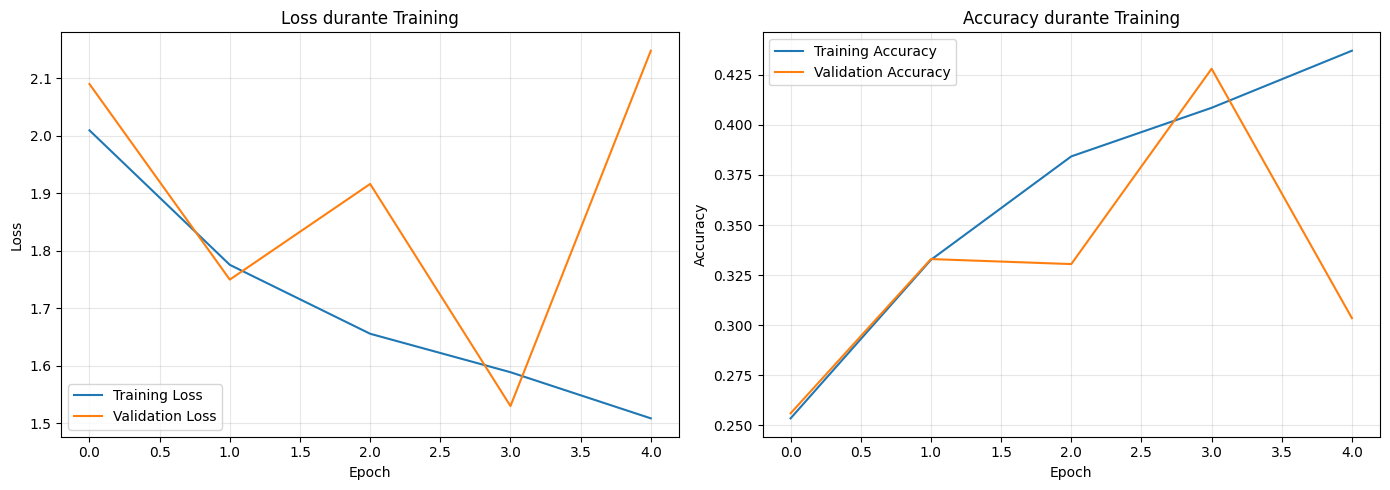

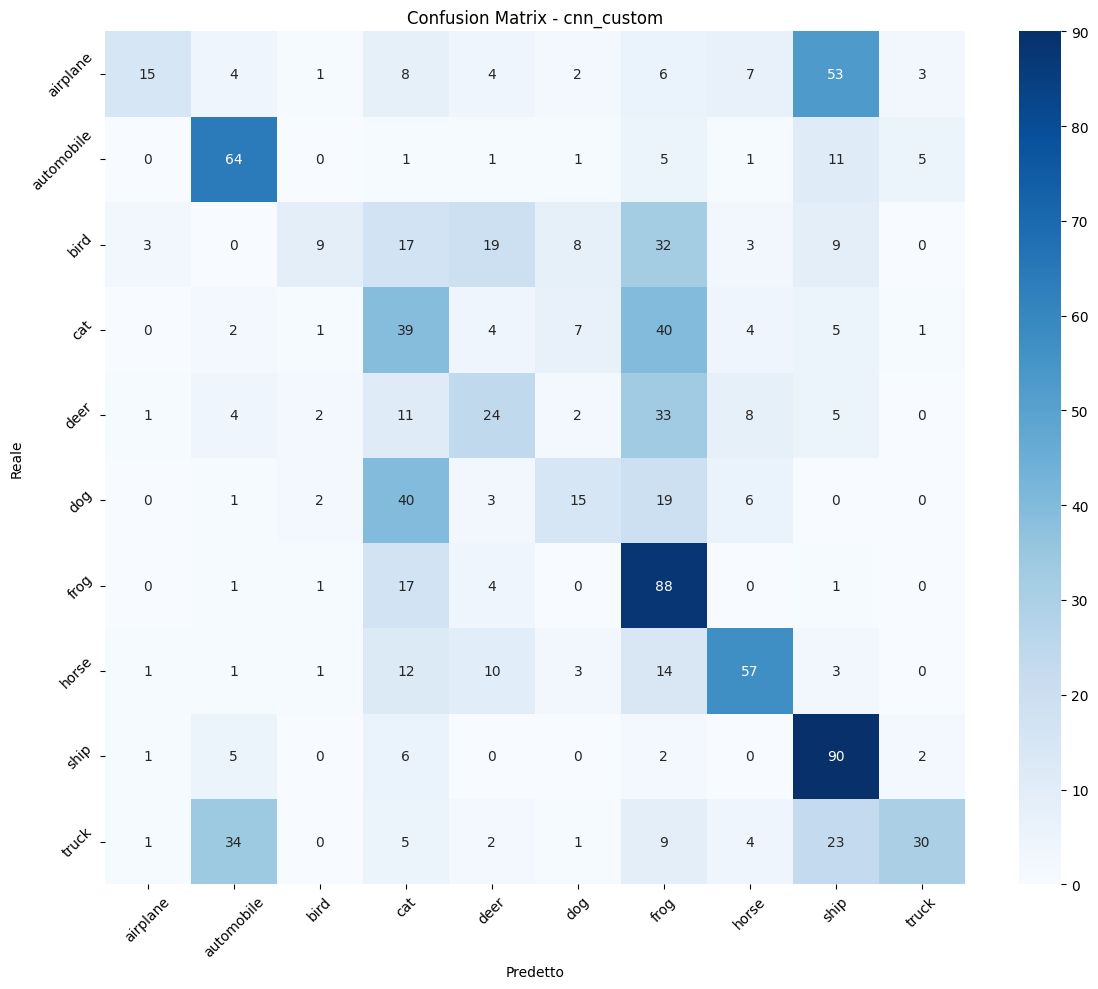

Test Loss: 1.5275
Test Accuracy: 0.4310

Classification Report:
              precision    recall  f1-score   support

    airplane       0.68      0.15      0.24       103
  automobile       0.55      0.72      0.62        89
        bird       0.53      0.09      0.15       100
         cat       0.25      0.38      0.30       103
        deer       0.34      0.27      0.30        90
         dog       0.38      0.17      0.24        86
        frog       0.35      0.79      0.49       112
       horse       0.63      0.56      0.59       102
        ship       0.45      0.85      0.59       106
       truck       0.73      0.28      0.40       109

    accuracy                           0.43      1000
   macro avg       0.49      0.42      0.39      1000
weighted avg       0.49      0.43      0.40      1000



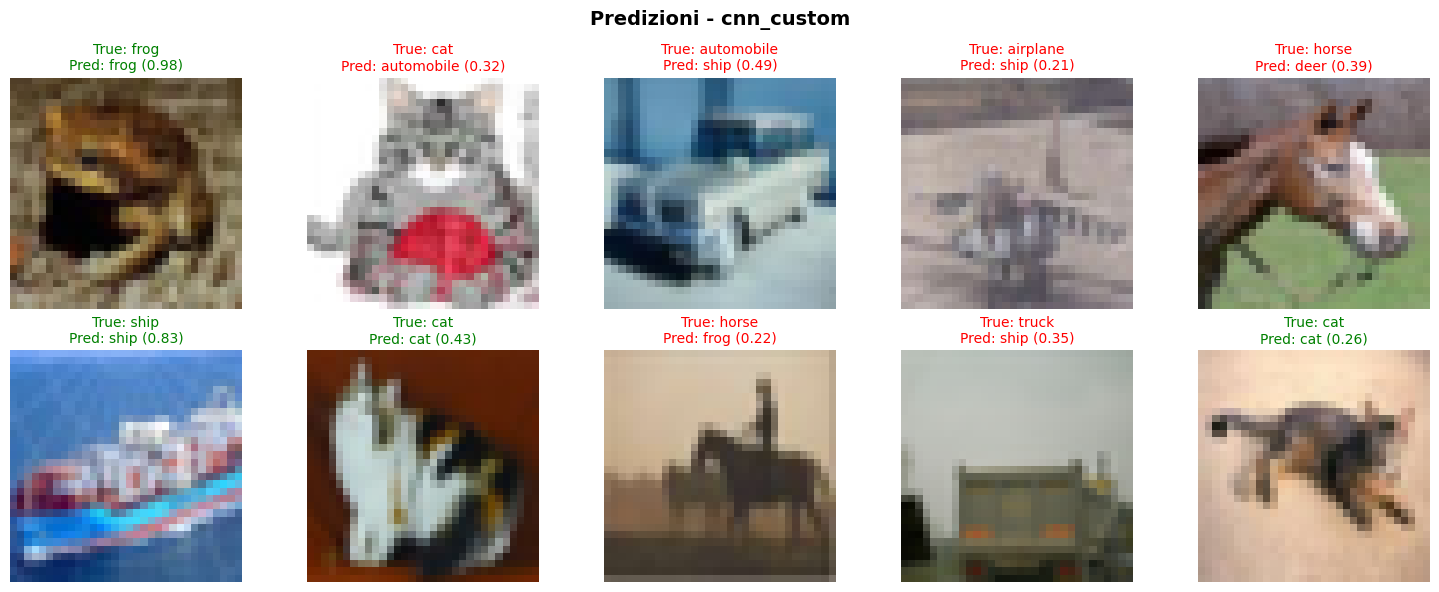


Test Transfer Learning:
Modello transfer_learning costruito
Parametri totali: 14,849,098
Modello compilato
Training senza data augmentation...
Epoch 1/5 - loss: 1.3643 - accuracy: 0.5309 - val_loss: 1.0528 - val_accuracy: 0.6335
Epoch 2/5 - loss: 0.9870 - accuracy: 0.6621 - val_loss: 0.9997 - val_accuracy: 0.6535
Epoch 3/5 - loss: 0.8862 - accuracy: 0.6909 - val_loss: 0.9806 - val_accuracy: 0.6660
Epoch 4/5 - loss: 0.8069 - accuracy: 0.7190 - val_loss: 0.9679 - val_accuracy: 0.6710
Epoch 5/5 - loss: 0.7370 - accuracy: 0.7494 - val_loss: 0.9748 - val_accuracy: 0.6705
Training completato
Fine-tuning: scongelamento ultimi 4 layer...
Epoch 1/3 - loss: 0.7803 - accuracy: 0.7372 - val_loss: 0.6974 - val_accuracy: 0.7695
Epoch 2/3 - loss: 0.7501 - accuracy: 0.7481 - val_loss: 0.6934 - val_accuracy: 0.7680
Epoch 3/3 - loss: 0.7235 - accuracy: 0.7585 - val_loss: 0.6883 - val_accuracy: 0.7690
Fine-tuning completato
Saved weights to pretrained_weights/nb06_sistema_tl_finetuned.pt


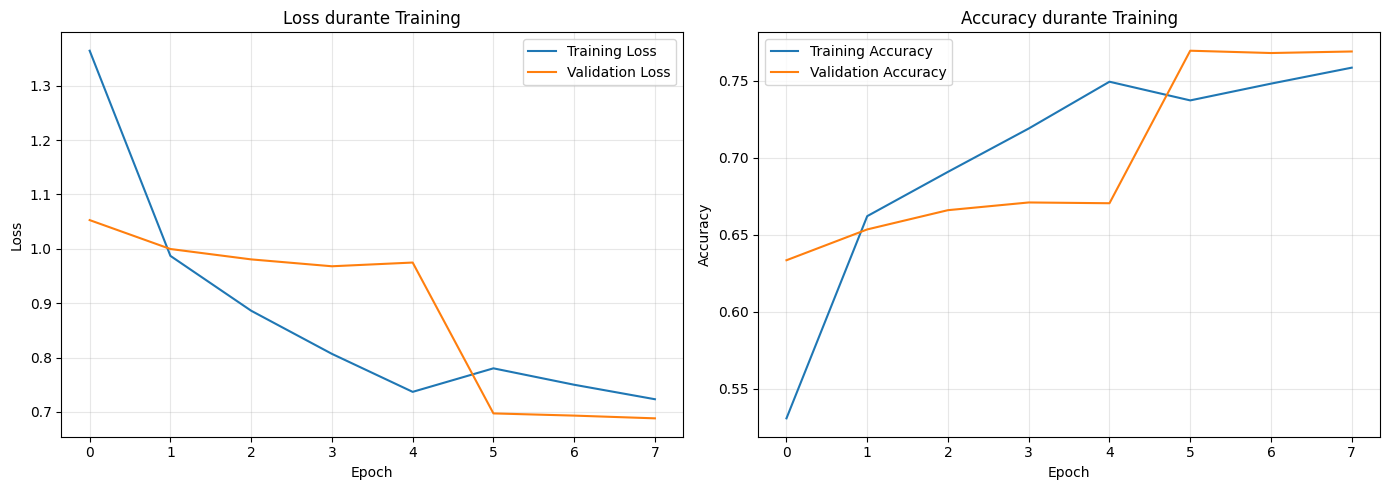

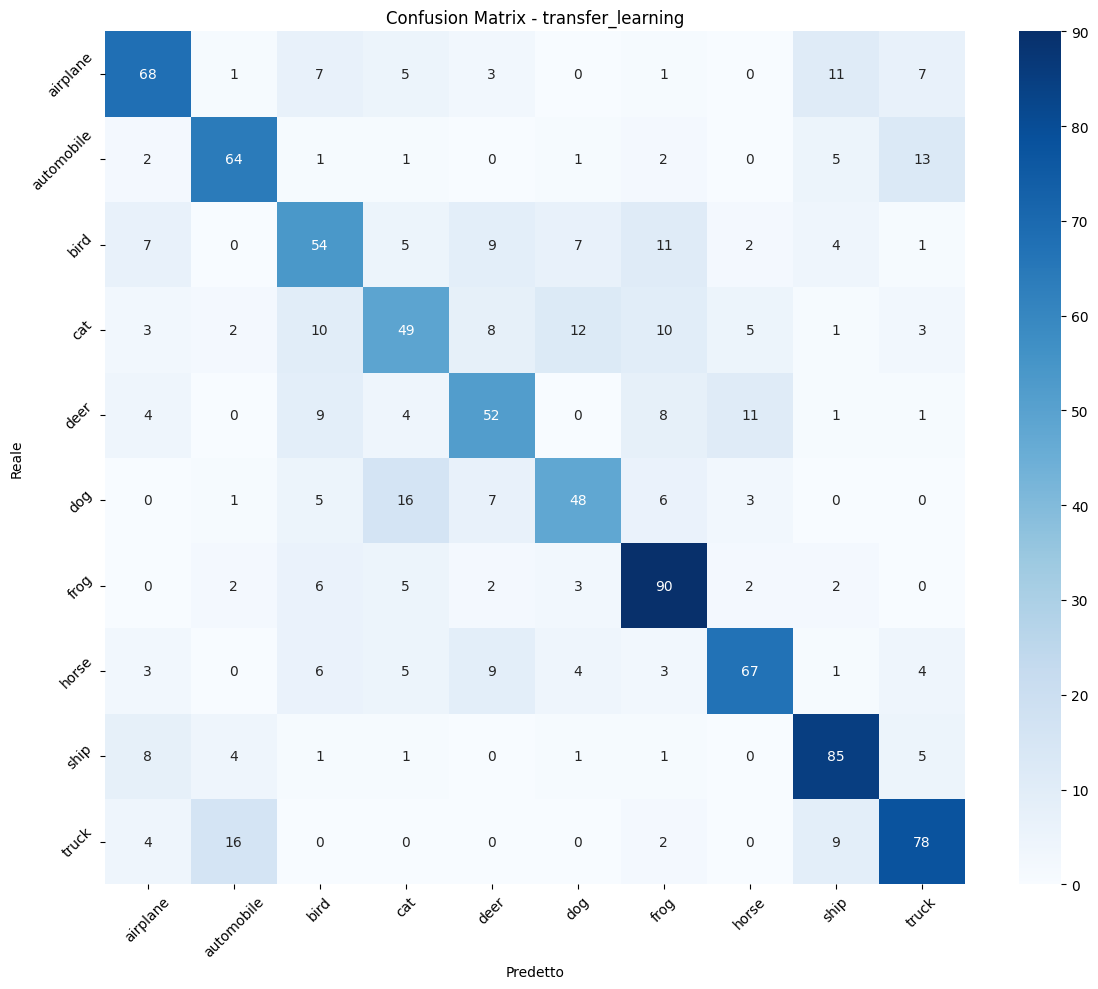

Test Loss: 1.0040
Test Accuracy: 0.6550

Classification Report:
              precision    recall  f1-score   support

    airplane       0.69      0.66      0.67       103
  automobile       0.71      0.72      0.72        89
        bird       0.55      0.54      0.54       100
         cat       0.54      0.48      0.51       103
        deer       0.58      0.58      0.58        90
         dog       0.63      0.56      0.59        86
        frog       0.67      0.80      0.73       112
       horse       0.74      0.66      0.70       102
        ship       0.71      0.80      0.76       106
       truck       0.70      0.72      0.71       109

    accuracy                           0.66      1000
   macro avg       0.65      0.65      0.65      1000
weighted avg       0.65      0.66      0.65      1000



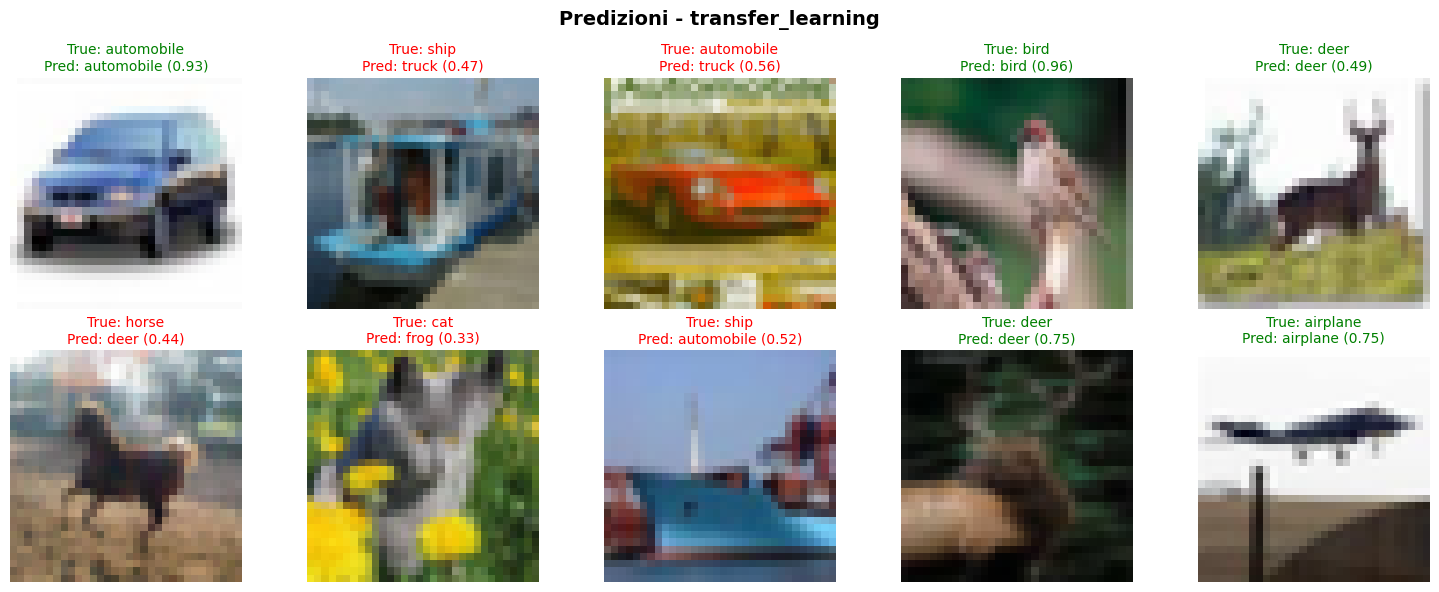


CONFRONTO FINALE
Accuracy CNN Custom: 0.4310
Accuracy Transfer Learning: 0.6550


In [20]:
class SistemaComputerVision:
    """
    Sistema completo per Computer Vision.
    Supporta training da zero e transfer learning.
    """

    def __init__(self, approccio='cnn_custom', base_model_name='VGG16'):
        self.approccio = approccio
        self.base_model_name = base_model_name
        self.model = None
        self.history = None
        self.class_names = None
        self.base_model = None
        self.input_shape = None
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def build_model(self, input_shape, num_classes):
        """Costruisce il modello in base all'approccio."""
        self.input_shape = input_shape
        C, H, W = input_shape  # PyTorch: CHW

        if self.approccio == 'cnn_custom':
            class CustomCNN(nn.Module):
                def __init__(self):
                    super().__init__()
                    self.features = nn.Sequential(
                        nn.Conv2d(C, 32, 3, padding=1),
                        nn.BatchNorm2d(32), nn.ReLU(),
                        nn.MaxPool2d(2, 2), nn.Dropout(0.2),

                        nn.Conv2d(32, 64, 3, padding=1),
                        nn.BatchNorm2d(64), nn.ReLU(),
                        nn.MaxPool2d(2, 2), nn.Dropout(0.3),

                        nn.Conv2d(64, 128, 3, padding=1),
                        nn.BatchNorm2d(128), nn.ReLU(),
                        nn.MaxPool2d(2, 2), nn.Dropout(0.4),

                        nn.Conv2d(128, 256, 3, padding=1),
                        nn.BatchNorm2d(256), nn.ReLU(),
                        nn.AdaptiveAvgPool2d((1, 1)),
                    )
                    self.classifier = nn.Sequential(
                        nn.Flatten(),
                        nn.Linear(256, 256), nn.ReLU(),
                        nn.BatchNorm1d(256), nn.Dropout(0.5),
                        nn.Linear(256, num_classes)
                    )
                def forward(self, x):
                    return self.classifier(self.features(x))

            self.model = CustomCNN().to(self.device)

        elif self.approccio == 'transfer_learning':
            model_map = {
                'VGG16': (models.vgg16, models.VGG16_Weights.IMAGENET1K_V1),
                'ResNet50': (models.resnet50, models.ResNet50_Weights.IMAGENET1K_V1),
                'EfficientNetB0': (models.efficientnet_b0, models.EfficientNet_B0_Weights.IMAGENET1K_V1),
            }
            if self.base_model_name not in model_map:
                raise ValueError(f"Base model non supportato: {self.base_model_name}")

            ModelClass, weights = model_map[self.base_model_name]
            self.base_model = ModelClass(weights=weights)

            for param in self.base_model.parameters():
                param.requires_grad = False

            # Get feature extractor
            if self.base_model_name == 'VGG16':
                features = self.base_model.features
                feat_dim = 512
            elif self.base_model_name == 'ResNet50':
                features = nn.Sequential(*list(self.base_model.children())[:-1])
                feat_dim = 2048
            elif self.base_model_name == 'EfficientNetB0':
                features = self.base_model.features
                feat_dim = 1280

            class TransferModel(nn.Module):
                def __init__(self, features, feat_dim, num_classes):
                    super().__init__()
                    self.features = features
                    self.pool = nn.AdaptiveAvgPool2d((1, 1))
                    self.classifier = nn.Sequential(
                        nn.Flatten(),
                        nn.Linear(feat_dim, 256), nn.ReLU(),
                        nn.BatchNorm1d(256), nn.Dropout(0.5),
                        nn.Linear(256, num_classes)
                    )
                def forward(self, x):
                    x = self.features(x)
                    x = self.pool(x)
                    return self.classifier(x)

            self.model = TransferModel(features, feat_dim, num_classes).to(self.device)

        total_params = sum(p.numel() for p in self.model.parameters())
        print(f"Modello {self.approccio} costruito")
        print(f"Parametri totali: {total_params:,}")

    def _normalize(self, X_tensor):
        """Normalizza con preprocessing specifico per il modello."""
        if self.approccio == 'transfer_learning':
            # ImageNet normalization
            mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(X_tensor.device)
            std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(X_tensor.device)
            return (X_tensor - mean) / std
        return X_tensor

    def compile_model(self, learning_rate=0.001):
        """Prepara optimizer (PyTorch non ha compile separato)."""
        self.lr = learning_rate
        print("Modello compilato")

    def train(self, X_np, y_np, X_val=None, y_val=None, epochs=20, batch_size=128, use_augmentation=True):
        """Addestra il modello."""
        _apply_aug = use_augmentation and self.approccio == 'cnn_custom'

        # Handle validation split on numpy arrays (needed for augmentation path)
        if X_val is not None and y_val is not None:
            X_train_np, y_train_np = X_np, y_np
            X_val_np, y_val_np = X_val, y_val
        else:
            n = len(X_np)
            n_val = int(0.2 * n)
            perm = np.random.permutation(n)
            X_val_np, y_val_np = X_np[perm[:n_val]], y_np[perm[:n_val]]
            X_train_np, y_train_np = X_np[perm[n_val:]], y_np[perm[n_val:]]

        # Validation loader (always tensor-based)
        X_v = torch.from_numpy(X_val_np.transpose(0, 3, 1, 2) if X_val_np.ndim == 4 and X_val_np.shape[-1] in [1,3] else X_val_np).float()
        y_v = torch.from_numpy(y_val_np).long()
        X_v = self._normalize(X_v)
        val_loader = DataLoader(TensorDataset(X_v, y_v), batch_size=batch_size, shuffle=False)

        if _apply_aug:
            # Define augmentation transforms inline (mirrors AugmentedDataset pattern)
            aug_transform = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(15),
                transforms.ColorJitter(brightness=0.2, contrast=0.2),
                transforms.RandomAffine(0, translate=(0.1, 0.1)),
                transforms.ToTensor(),
            ])

            class _AugDataset(torch.utils.data.Dataset):
                """Augmented dataset: stores NHWC float32 numpy, applies PIL transforms."""
                def __init__(self, images_np, labels_np, transform):
                    self.images = images_np
                    self.labels = labels_np
                    self.transform = transform
                def __len__(self):
                    return len(self.images)
                def __getitem__(self, idx):
                    img = self.images[idx]
                    label = self.labels[idx]
                    img_uint8 = (img * 255).astype(np.uint8)
                    pil_img = Image.fromarray(img_uint8)
                    img_tensor = self.transform(pil_img)
                    return img_tensor, torch.tensor(label, dtype=torch.long)

            train_loader = DataLoader(
                _AugDataset(X_train_np, y_train_np, aug_transform),
                batch_size=batch_size, shuffle=True
            )
            print("Training con data augmentation...")
        else:
            X_t = torch.from_numpy(X_train_np.transpose(0, 3, 1, 2) if X_train_np.ndim == 4 and X_train_np.shape[-1] in [1,3] else X_train_np).float()
            y_t = torch.from_numpy(y_train_np).long()
            X_t = self._normalize(X_t)
            train_loader = DataLoader(TensorDataset(X_t, y_t), batch_size=batch_size, shuffle=True)
            print("Training senza data augmentation...")

        self.history = train_model(
            self.model, train_loader, val_loader,
            epochs=epochs, lr=self.lr, patience=5, patience_lr=3, device=self.device
        )
        print("Training completato")

    def fine_tune(self, X_np, y_np, X_val=None, y_val=None, epochs=10, layers_to_unfreeze=4):
        """Fine-tuning per transfer learning."""
        if self.approccio != 'transfer_learning':
            raise ValueError("Fine-tuning solo per transfer learning")

        # Unfreeze last N layers of features
        feature_layers = list(self.model.features.children())
        for layer in feature_layers[-layers_to_unfreeze:]:
            for param in layer.parameters():
                param.requires_grad = True

        print(f"Fine-tuning: scongelamento ultimi {layers_to_unfreeze} layer...")

        old_lr = self.lr
        self.lr = 1e-5

        X_t = torch.from_numpy(X_np.transpose(0, 3, 1, 2) if X_np.ndim == 4 and X_np.shape[-1] in [1,3] else X_np).float()
        y_t = torch.from_numpy(y_np).long()
        X_t = self._normalize(X_t)

        if X_val is not None and y_val is not None:
            X_v = torch.from_numpy(X_val.transpose(0, 3, 1, 2) if X_val.ndim == 4 and X_val.shape[-1] in [1,3] else X_val).float()
            y_v = torch.from_numpy(y_val).long()
            X_v = self._normalize(X_v)
        else:
            n = len(X_t)
            n_val = int(0.2 * n)
            perm = torch.randperm(n)
            X_v, y_v = X_t[perm[:n_val]], y_t[perm[:n_val]]
            X_t, y_t = X_t[perm[n_val:]], y_t[perm[n_val:]]

        train_loader = DataLoader(TensorDataset(X_t, y_t), batch_size=128, shuffle=True)
        val_loader = DataLoader(TensorDataset(X_v, y_v), batch_size=128, shuffle=False)

        ft_history = train_model(
            self.model, train_loader, val_loader,
            epochs=epochs, lr=self.lr, patience=3, patience_lr=2, device=self.device
        )

        if self.history is not None:
            for key in self.history:
                if key in ft_history:
                    self.history[key].extend(ft_history[key])
        else:
            self.history = ft_history

        self.lr = old_lr
        print("Fine-tuning completato")

    def evaluate(self, X_np, y_np, class_names=None):
        """Valuta il modello."""
        self.class_names = class_names

        X_t = torch.from_numpy(X_np.transpose(0, 3, 1, 2) if X_np.ndim == 4 and X_np.shape[-1] in [1,3] else X_np).float()
        y_t = torch.from_numpy(y_np).long()
        X_t = self._normalize(X_t)

        t_loss, t_acc, y_pred, y_proba = evaluate_model(self.model, X_t, y_t, device=self.device)

        report = classification_report(y_np, y_pred, target_names=class_names)
        cm = confusion_matrix(y_np, y_pred)

        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predetto')
        plt.ylabel('Reale')
        plt.title(f'Confusion Matrix - {self.approccio}')
        plt.xticks(rotation=45)
        plt.yticks(rotation=45)
        plt.tight_layout()
        plt.show()

        print(f"Test Loss: {t_loss:.4f}")
        print(f"Test Accuracy: {t_acc:.4f}")
        print(f"\nClassification Report:\n{report}")

        return {'accuracy': t_acc, 'loss': t_loss, 'confusion_matrix': cm, 'classification_report': report}

    def visualize_predictions(self, X_np, y_np, n=10):
        """Visualizza predizioni su sample."""
        indices = np.random.choice(len(X_np), min(n, len(X_np)), replace=False)
        sample_images = X_np[indices]
        sample_labels = y_np[indices]

        X_t = torch.from_numpy(sample_images.transpose(0, 3, 1, 2) if sample_images.ndim == 4 and sample_images.shape[-1] in [1,3] else sample_images).float()
        X_t = self._normalize(X_t)

        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X_t.to(self.device))
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
        pred_labels = probs.argmax(axis=1)

        n_cols = 5
        n_rows = (n + n_cols - 1) // n_cols
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
        axes = axes.flatten() if n > 1 else [axes]

        for i in range(min(n, len(sample_images))):
            if i < len(axes):
                axes[i].imshow(sample_images[i])
                tl, pl = sample_labels[i], pred_labels[i]
                color = 'green' if tl == pl else 'red'
                tn = self.class_names[tl] if self.class_names else str(tl)
                pn = self.class_names[pl] if self.class_names else str(pl)
                conf = probs[i][pl]
                axes[i].set_title(f"True: {tn}\nPred: {pn} ({conf:.2f})", color=color, fontsize=10)
                axes[i].axis('off')

        for i in range(len(sample_images), len(axes)):
            axes[i].axis('off')

        plt.suptitle(f'Predizioni - {self.approccio}', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

    def plot_training_history(self):
        """Visualizza learning curves."""
        if self.history is None:
            raise ValueError("Nessuno storico disponibile")

        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        axes[0].plot(self.history['loss'], label='Training Loss')
        if 'val_loss' in self.history:
            axes[0].plot(self.history['val_loss'], label='Validation Loss')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].set_title('Loss durante Training')
        axes[0].legend()
        axes[0].grid(alpha=0.3)

        axes[1].plot(self.history['accuracy'], label='Training Accuracy')
        if 'val_accuracy' in self.history:
            axes[1].plot(self.history['val_accuracy'], label='Validation Accuracy')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Accuracy')
        axes[1].set_title('Accuracy durante Training')
        axes[1].legend()
        axes[1].grid(alpha=0.3)

        plt.tight_layout()
        plt.show()

    def save_model(self, filepath):
        """Salva il modello."""
        torch.save(self.model.state_dict(), filepath)
        print(f"Modello salvato in {filepath}")

    def load_model(self, filepath):
        """Carica il modello."""
        self.model.load_state_dict(torch.load(filepath, map_location=self.device))
        print(f"Modello caricato da {filepath}")


# ===== Test del sistema =====
print("=" * 60)
print("TEST SISTEMA COMPUTER VISION")
print("=" * 60)

# FIX: usiamo X_train_norm e X_test_norm (CIFAR-10)

print("\n" + "=" * 60)
print("Test CNN Custom:")
print("=" * 60)
sistema_custom = SistemaComputerVision(approccio='cnn_custom')
sistema_custom.build_model(input_shape=(3, 32, 32), num_classes=10)
sistema_custom.compile_model()

_wf_custom = os.path.join(WEIGHTS_DIR, 'nb06_sistema_custom.pt')
if os.path.exists(_wf_custom):
    sistema_custom.model.load_state_dict(torch.load(_wf_custom, map_location=device, weights_only=True))
    print(f"Loaded pretrained weights from {_wf_custom}")
else:
    sistema_custom.train(
        X_train_norm[:10000], y_train[:10000],
        epochs=5, use_augmentation=True
    )
    torch.save(sistema_custom.model.state_dict(), _wf_custom)
    print(f"Saved weights to {_wf_custom}")

if sistema_custom.history is not None:
    sistema_custom.plot_training_history()
else:
    print("Using pretrained weights - training curves not available")
metriche = sistema_custom.evaluate(
    X_test_norm[:1000], y_test[:1000], class_names=class_names
)
sistema_custom.visualize_predictions(
    X_test_norm[:1000], y_test[:1000], n=10
)

print("\n" + "=" * 60)
print("Test Transfer Learning:")
print("=" * 60)
sistema_tl = SistemaComputerVision(
    approccio='transfer_learning', base_model_name='VGG16'
)
sistema_tl.build_model(input_shape=(3, 32, 32), num_classes=10)
sistema_tl.compile_model()

_wf_tl = os.path.join(WEIGHTS_DIR, 'nb06_sistema_tl_finetuned.pt')
if os.path.exists(_wf_tl):
    sistema_tl.model.load_state_dict(torch.load(_wf_tl, map_location=device, weights_only=True))
    print(f"Loaded pretrained weights from {_wf_tl}")
else:
    sistema_tl.train(
        X_train_norm[:10000], y_train[:10000],
        epochs=5, use_augmentation=False
    )
    torch.save(sistema_tl.model.state_dict(), os.path.join(WEIGHTS_DIR, 'nb06_sistema_tl_trained.pt'))
    sistema_tl.fine_tune(
        X_train_norm[:10000], y_train[:10000],
        epochs=3, layers_to_unfreeze=4
    )
    torch.save(sistema_tl.model.state_dict(), _wf_tl)
    print(f"Saved weights to {_wf_tl}")

if sistema_tl.history is not None:
    sistema_tl.plot_training_history()
else:
    print("Using pretrained weights - training curves not available")
metriche_tl = sistema_tl.evaluate(
    X_test_norm[:1000], y_test[:1000], class_names=class_names
)
sistema_tl.visualize_predictions(
    X_test_norm[:1000], y_test[:1000], n=10
)

# Confronto finale
print("\n" + "=" * 60)
print("CONFRONTO FINALE")
print("=" * 60)
print(f"Accuracy CNN Custom: {metriche['accuracy']:.4f}")
print(f"Accuracy Transfer Learning: {metriche_tl['accuracy']:.4f}")

---

## Conclusioni

In questo notebook abbiamo esplorato:

- **Architettura CNN**: layer convoluzionali, pooling, feature hierarchies
- **Implementazione CNN**: da semplice ad avanzata con CIFAR-10
- **Data Augmentation**: per migliorare generalizzazione
- **Transfer Learning**: VGG16, ResNet50, EfficientNet
- **Fine-tuning**: scongelamento layer e re-training
- **API Computer Vision**: deployment via REST API
- **Visualizzazione**: feature maps per interpretabilita'

### Concetti chiave da ricordare

1. **CNN sono specializzate per immagini**: condivisione parametri e invarianza spaziale
2. **Transfer Learning e' potentissimo**: richiede meno dati e tempo
3. **Fine-tuning > Feature Extraction**: se hai abbastanza dati
4. **Learning rate basso per fine-tuning**: evita di "rompere" pesi pre-trained
5. **Data Augmentation e' essenziale**: per dataset piccoli
6. **GlobalAveragePooling > Flatten**: meno parametri, meno overfitting

### Workflow consigliato per nuovi progetti

1. **Inizia con transfer learning**: modello pre-trained + classificatore custom
2. **Train classificatore**: congela base model
3. **Valuta performance**: se buone, stop qui
4. **Se serve piu' accuracy**: fine-tune ultimi layer
5. **Data augmentation**: sempre, specialmente se dataset piccolo
6. **Solo se necessario**: train CNN da zero

### Prossimi passi

Nel prossimo notebook affronteremo:
- Natural Language Processing
- Preprocessing testi
- Modelli tradizionali (TF-IDF, Bag of Words)
- Embeddings e Word2Vec

### Risorse per approfondire

- [CS231n: Convolutional Neural Networks - Stanford](http://cs231n.stanford.edu/)
- [Deep Learning for Computer Vision - MIT](http://introtodeeplearning.com/)
- [PyTorch Image Classification Tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)
- [Transfer Learning with PyTorch](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
- [EfficientNet Paper](https://arxiv.org/abs/1905.11946)